## Trilateration Notebook
### Experiments based on the computation of the intersection of three or more beacons to compute the user's position

### Imports
Imports of required libraries

In [1]:
#CSV Related
import pandas as pd
import csv

# Machine Learning
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import  accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.model_selection import train_test_split,KFold,StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.pipeline import make_pipeline
import sklearn
import scipy
import scipy.optimize as opt

#Graphical Display
%matplotlib inline
import math
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.despine()
from pandas.plotting import scatter_matrix

plt.style.use('seaborn-whitegrid')

#Additional Helper Libraries
from operator import itemgetter
import re

import json

import localization as lx

<Figure size 432x288 with 0 Axes>

### Load File
Function that allows to load a file from disk

In [2]:
#Function that reads a csv file and structures the data accordingly
def load_file(filename):
    dataset = pd.read_csv(filename)
    return dataset

### Replace 0 with Nan RSSI Values

In [3]:
def replace_features_nan(dataset):
    dataset['rssi_Value'] = dataset['rssi_Value'].replace(0,np.nan)
    dataset['rolling_mean_rssi'] = dataset['rolling_mean_rssi'].replace(0,np.nan)

### Initialize Dataset
Initialization of the data from the file

In [4]:
dataset = load_file('trilateration_test.csv')
display(dataset)
display(dataset.shape)

,X,Y,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3,E1:E9:C3:D9:09:C3
0,-2.0,-1.0,4.000000,5.656854,0.000000
1,-2.0,0.0,3.000000,5.000000,1.000000
2,-2.0,1.0,2.000000,4.472136,2.000000
3,-2.0,2.0,1.000000,4.123106,3.000000
4,-2.0,3.0,0.000000,4.000000,4.000000
5,-1.0,-1.0,4.123106,5.000000,1.000000
6,-1.0,0.0,3.162278,4.242641,1.414214
7,-1.0,1.0,2.236068,3.605551,2.236068
8,-1.0,2.0,1.414214,3.162278,3.162278
9,-1.0,3.0,1.000000,3.000000,4.123106


(25, 5)

In [5]:
dataset_double = load_file('trilateration_test_0.5.csv')
display(dataset_double)
display(dataset_double.shape)

,X,Y,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3,E1:E9:C3:D9:09:C3
0,-2.0,-1.0,4.000000,5.656854,0.000000
1,-2.0,-0.5,3.500000,5.315073,0.500000
2,-2.0,0.0,3.000000,5.000000,1.000000
3,-2.0,0.5,2.500000,4.716991,1.500000
4,-2.0,1.0,2.000000,4.472136,2.000000
...,...,...,...,...,...
95,2.5,1.5,4.743416,1.581139,5.147815
96,2.5,2.0,4.609772,1.118034,5.408327
97,2.5,2.5,4.527693,0.707107,5.700877
98,2.5,3.0,4.500000,0.500000,6.020797


(100, 5)

In [6]:
dataset_10cm = load_file('trilateration_test_0.10_meters.csv')
display(dataset_10cm)
display(dataset_10cm.shape)

,X,Y,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3,E1:E9:C3:D9:09:C3
0,-2.0,-1.0,4.000000,5.656854,0.000000
1,-2.0,-0.9,3.900000,5.586591,0.100000
2,-2.0,-0.8,3.800000,5.517246,0.200000
3,-2.0,-0.7,3.700000,5.448853,0.300000
4,-2.0,-0.6,3.600000,5.381450,0.400000
...,...,...,...,...,...
2495,2.9,3.5,4.925444,1.029563,6.652819
2496,2.9,3.6,4.936598,1.081665,6.720863
2497,2.9,3.7,4.949747,1.140175,6.789698
2498,2.9,3.8,4.964877,1.204159,6.859300


(2500, 5)

In [7]:
dataset_classification = load_file('trilateration_test_classification.csv')
display(dataset_classification)
display(dataset_classification.shape)

,X,Y,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3,E1:E9:C3:D9:09:C3,Zone
0,-2.0,-1.0,4.000000,5.656854,0.000000,Public
1,-2.0,0.0,3.000000,5.000000,1.000000,Social
2,-2.0,1.0,2.000000,4.472136,2.000000,Social
3,-2.0,2.0,1.000000,4.123106,3.000000,Social
4,-2.0,3.0,0.000000,4.000000,4.000000,Personal
5,-1.0,-1.0,4.123106,5.000000,1.000000,Public
6,-1.0,0.0,3.162278,4.242641,1.414214,Social
7,-1.0,1.0,2.236068,3.605551,2.236068,Social
8,-1.0,2.0,1.414214,3.162278,3.162278,Social
9,-1.0,3.0,1.000000,3.000000,4.123106,Personal


(25, 6)

### Initialize Training Dataset
Initialization of the data from the file

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,0.0,0.0,-48,-48.000000,Personal,0.0
1,0.0,0.0,-48,-48.000000,Personal,0.0
2,0.0,0.0,-48,-48.000000,Personal,0.0
3,0.0,0.0,-48,-48.000000,Personal,0.0
4,0.0,0.0,-46,-47.600000,Personal,0.0
...,...,...,...,...,...,...
24829,0.0,4.5,-92,-90.480000,Public,4.5
24830,0.0,4.5,-93,-90.576923,Public,4.5
24831,0.0,4.5,-90,-90.555556,Public,4.5
24832,0.0,4.5,-90,-90.535714,Public,4.5


(24834, 6)

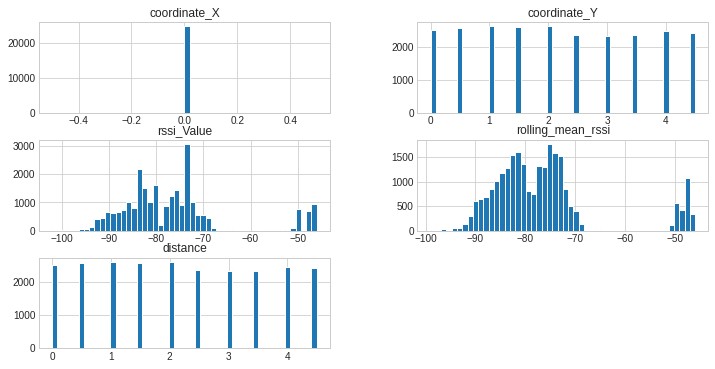

In [8]:
train_dataset = load_file('../PROXIMITY/dataset_train_university.csv')
positions = train_dataset['coordinate_Y']
train_dataset['distance'] = positions
replace_features_nan(train_dataset)
display(train_dataset)
display(train_dataset.shape)
train_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Initialize Test Set

,BLE Beacon,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance
0,FF:20:88:3C:97:E7,1.0,2.0,-84,-84.000000,NaN,2.0
1,FF:20:88:3C:97:E7,1.0,2.0,-83,-83.500000,NaN,2.0
2,FF:20:88:3C:97:E7,1.0,2.0,-84,-83.666667,NaN,2.0
3,FF:20:88:3C:97:E7,1.0,2.0,-83,-83.500000,NaN,2.0
4,FF:20:88:3C:97:E7,1.0,2.0,-85,-83.800000,NaN,2.0
...,...,...,...,...,...,...,...
13473,E1:E9:C3:D9:09:C3,0.0,0.0,-80,-81.483636,NaN,0.0
13474,E1:E9:C3:D9:09:C3,0.0,0.0,-83,-81.489130,NaN,0.0
13475,E1:E9:C3:D9:09:C3,0.0,0.0,-85,-81.501805,NaN,0.0
13476,E1:E9:C3:D9:09:C3,0.0,0.0,-84,-81.510791,NaN,0.0


(13478, 7)

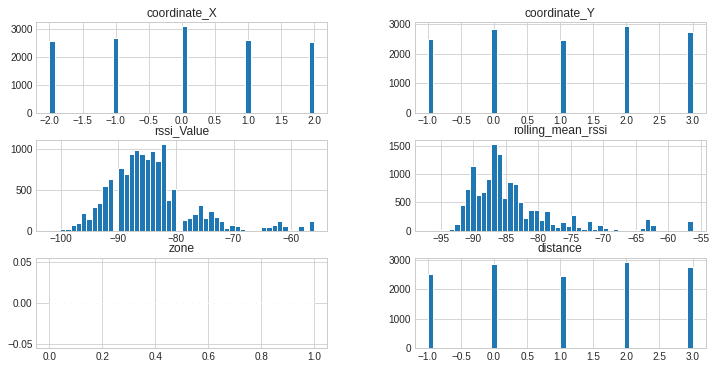

In [9]:
test_dataset = load_file('dataset_test_trilateration_university.csv')
positions = test_dataset['coordinate_Y']
test_dataset['distance'] = positions
replace_features_nan(test_dataset)
display(test_dataset)
display(test_dataset.shape)
test_dataset.hist(bins=50,figsize=(12,6))
plt.show()

### File Overall Description
Usage of describe pandas function on the dataset

In [10]:
display(dataset.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
X,25.0,0.000000,1.443376,-2.0,-1.000000,0.000000,1.000000,2.000000
Y,25.0,1.000000,1.443376,-1.0,0.000000,1.000000,2.000000,3.000000
FF:20:88:3C:97:E7,25.0,3.173617,1.417215,0.0,2.236068,3.162278,4.123106,5.656854
CA:E0:7D:11:26:B3,25.0,3.173617,1.417215,0.0,2.236068,3.162278,4.123106,5.656854
E1:E9:C3:D9:09:C3,25.0,3.173617,1.417215,0.0,2.236068,3.162278,4.123106,5.656854


In [11]:
display(dataset_double.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
X,100.0,0.250000,1.443376,-2.0,-1.000000,0.250000,1.500000,2.500000
Y,100.0,1.250000,1.443376,-1.0,0.000000,1.250000,2.500000,3.500000
FF:20:88:3C:97:E7,100.0,3.218583,1.381964,0.0,2.207381,3.427051,4.272002,6.020797
CA:E0:7D:11:26:B3,100.0,2.915799,1.328823,0.0,2.000000,3.041381,4.007782,5.656854
E1:E9:C3:D9:09:C3,100.0,3.501523,1.417544,0.0,2.500000,3.622803,4.548212,6.363961


In [12]:
display(dataset_10cm.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
X,2500.0,0.450000,1.443376,-2.000000e+00,-0.800000,0.450000,1.700000,2.900000
Y,2500.0,1.450000,1.443376,-1.000000e+00,0.200000,1.450000,2.700000,3.900000
FF:20:88:3C:97:E7,2500.0,3.270465,1.369236,8.881784e-16,2.256103,3.401470,4.326662,6.325346
CA:E0:7D:11:26:B3,2500.0,2.716636,1.261159,3.662053e-15,1.702939,2.829311,3.712142,5.656854
E1:E9:C3:D9:09:C3,2500.0,3.761195,1.422750,0.000000e+00,2.758623,3.921097,4.818971,6.929646


In [13]:
display(dataset_classification.describe().transpose())

,count,mean,std,min,25%,50%,75%,max
X,25.0,0.000000,1.443376,-2.0,-1.000000,0.000000,1.000000,2.000000
Y,25.0,1.000000,1.443376,-1.0,0.000000,1.000000,2.000000,3.000000
FF:20:88:3C:97:E7,25.0,3.173617,1.417215,0.0,2.236068,3.162278,4.123106,5.656854
CA:E0:7D:11:26:B3,25.0,3.173617,1.417215,0.0,2.236068,3.162278,4.123106,5.656854
E1:E9:C3:D9:09:C3,25.0,3.173617,1.417215,0.0,2.236068,3.162278,4.123106,5.656854


### % of Missing Values on Test Dataset

In [14]:
def compute_missing_values(dataset): 
    missing_values = dataset.isnull().sum()
    missing_values_dataset = pd.DataFrame(missing_values,columns=['Missing Values'])
    missing_percentage = (dataset.isnull().sum() / dataset.count())
    missing_percentage_dataset = pd.DataFrame(missing_percentage,columns=['% of Missing Values'])
    missing_dataset = missing_values_dataset.join(missing_percentage_dataset)
    display(missing_dataset)

In [15]:
compute_missing_values(test_dataset)
compute_missing_values(train_dataset)

,Missing Values,% of Missing Values
BLE Beacon,0,0.0
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,13478,inf
distance,0,0.0


,Missing Values,% of Missing Values
coordinate_X,0,0.0
coordinate_Y,0,0.0
rssi_Value,0,0.0
rolling_mean_rssi,0,0.0
zone,0,0.0
distance,0,0.0


### Overall Histogram of dataset atributes

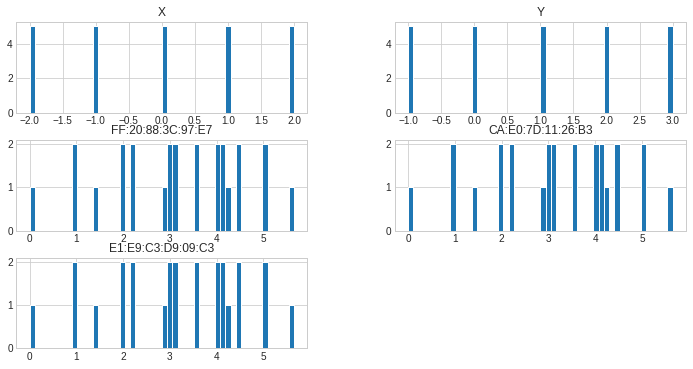

In [16]:
dataset.hist(bins=50,figsize=(12,6))
plt.show()

### Beacon RSSI Display of Test Dataset
Graphical display of the rssi values recorded at each position

/home/pedro/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


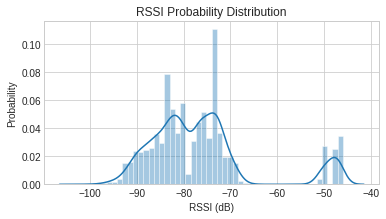

In [17]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

#NOTE: distplot is deprecated. Replace with https://seaborn.pydata.org/generated/seaborn.displot.html
sns.distplot(train_dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

/home/pedro/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


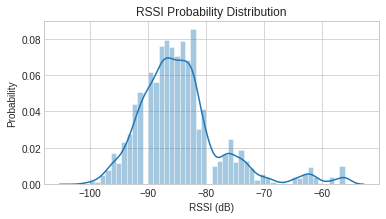

In [18]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')

#NOTE: distplot is deprecated. Replace with https://seaborn.pydata.org/generated/seaborn.displot.html
sns.distplot(test_dataset['rssi_Value'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Beacon Rolling Mean RSSI Display of Test Dataset
Graphical adisplay of the rolling mean value recorded at each position

/home/pedro/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


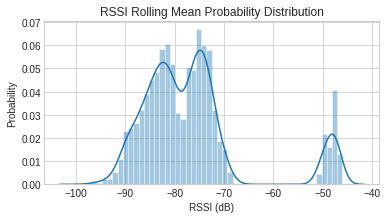

In [19]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(train_dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

/home/pedro/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


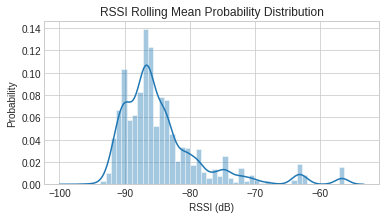

In [20]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Rolling Mean Probability Distribution')
# The KDE plot for the Rolling Mean column
sns.distplot(test_dataset['rolling_mean_rssi'])
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Graphical Display of RSSI/Rolling Mean Distribution of Test Dataset
Graphical display of the previous measures - rssi and rolling mean

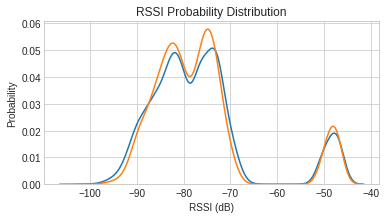

In [21]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(train_dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(train_dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

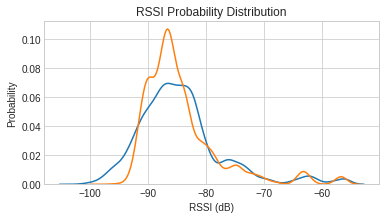

In [22]:
plt.figure(figsize=(6,3))
# Title
plt.title('RSSI Probability Distribution')
# The KDE plot for the RSSI column
sns.kdeplot(test_dataset['rssi_Value'], label='RSSI')
# The KDE plot for the Rolling Mean column
sns.kdeplot(test_dataset['rolling_mean_rssi'], label='Rolling Mean RSSI')
# The X Label
plt.xlabel('RSSI (dB)')
# The Y Label
plt.ylabel('Probability')
# Show the plot
plt.show()

### Correlations
Check how much each attribute collerates with each other. Valures frange from -1 to 1. Close to 1 means a strong positive correlation.

In [23]:
def compute_correlations(dataset,attribute,flag=0):
    corr_matrix = dataset.corr()
    display(corr_matrix)
    display(corr_matrix[attribute].sort_values(ascending=False))
    if flag == 1:
        attributes = ["distance","rssi_Value", "rolling_mean_rssi"]
        scatter_matrix(dataset[attributes], figsize=(12, 8))

,X,Y,FF:20:88:3C:97:E7,CA:E0:7D:11:26:B3,E1:E9:C3:D9:09:C3
X,1.000000,0.000000,0.683977,-0.683977,0.683977
Y,0.000000,1.000000,-0.683977,-0.683977,0.683977
FF:20:88:3C:97:E7,0.683977,-0.683977,1.000000,-0.026425,-0.026425
CA:E0:7D:11:26:B3,-0.683977,-0.683977,-0.026425,1.000000,-0.877369
E1:E9:C3:D9:09:C3,0.683977,0.683977,-0.026425,-0.877369,1.000000


X                    1.000000
E1:E9:C3:D9:09:C3    0.683977
FF:20:88:3C:97:E7    0.683977
Y                    0.000000
CA:E0:7D:11:26:B3   -0.683977
Name: X, dtype: float64

,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,distance
coordinate_X,NaN,NaN,NaN,NaN,NaN
coordinate_Y,NaN,1.000000,-0.723705,-0.741381,1.000000
rssi_Value,NaN,-0.723705,1.000000,0.958999,-0.723705
rolling_mean_rssi,NaN,-0.741381,0.958999,1.000000,-0.741381
distance,NaN,1.000000,-0.723705,-0.741381,1.000000


distance             1.000000
coordinate_Y         1.000000
rssi_Value          -0.723705
rolling_mean_rssi   -0.741381
coordinate_X              NaN
Name: distance, dtype: float64

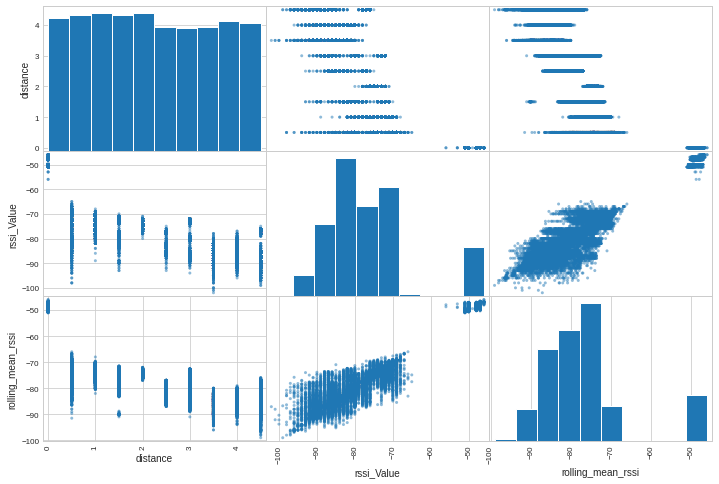

In [24]:
compute_correlations(dataset,'X')
compute_correlations(train_dataset,'distance',1)

### Data Cleaning
Fill in missing values and fix/remove outliers

In [25]:
def compute_data_cleaning(dataset,feature):
    nan_filler = dataset[feature].min()*1.010
    dataset[feature] = dataset[feature].fillna(nan_filler) # Fill missing values

In [26]:
compute_data_cleaning(train_dataset,'rssi_Value')
compute_data_cleaning(train_dataset,'rolling_mean_rssi')
compute_data_cleaning(test_dataset,'rssi_Value')
compute_data_cleaning(test_dataset,'rolling_mean_rssi')

### Dealing with Categorical Data
Using Hot-Encoder or Label Encoder to convert text/categorical data into numerical data. ML algorithms prefer it

In [27]:
label_encoder = LabelEncoder()
def compute_encoder(categorical_data,flag):
    if flag == 0:
        labels = label_encoder.fit_transform(categorical_data)
    else:
        labels = label_encoder.transform(categorical_data)
    return labels

In [28]:
categorical_zone = train_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
train_dataset['labels'] = zone_changed
display(train_dataset.head(5))

Previous Categorical Data


,zone
0,Personal
1,Personal
2,Personal
3,Personal
4,Personal
...,...
24829,Public
24830,Public
24831,Public
24832,Public


After One Hot Encoder


/home/pedro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance,labels
0,0.0,0.0,-48,-48.0,Personal,0.0,0
1,0.0,0.0,-48,-48.0,Personal,0.0,0
2,0.0,0.0,-48,-48.0,Personal,0.0,0
3,0.0,0.0,-48,-48.0,Personal,0.0,0
4,0.0,0.0,-46,-47.6,Personal,0.0,0


In [29]:
categorical_zone = test_dataset[['zone']]
print("Previous Categorical Data")
display(categorical_zone)
zone_changed = compute_encoder(categorical_zone,0)
print("After One Hot Encoder")
test_dataset['labels'] = zone_changed
display(test_dataset.head(5))

Previous Categorical Data


,zone
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
13473,NaN
13474,NaN
13475,NaN
13476,NaN


After One Hot Encoder


/home/pedro/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


,BLE Beacon,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance,labels
0,FF:20:88:3C:97:E7,1.0,2.0,-84,-84.000000,NaN,2.0,0
1,FF:20:88:3C:97:E7,1.0,2.0,-83,-83.500000,NaN,2.0,8977
2,FF:20:88:3C:97:E7,1.0,2.0,-84,-83.666667,NaN,2.0,8978
3,FF:20:88:3C:97:E7,1.0,2.0,-83,-83.500000,NaN,2.0,8979
4,FF:20:88:3C:97:E7,1.0,2.0,-85,-83.800000,NaN,2.0,8980


### Plot Dataset
Graphical Display of the observations in the dataset

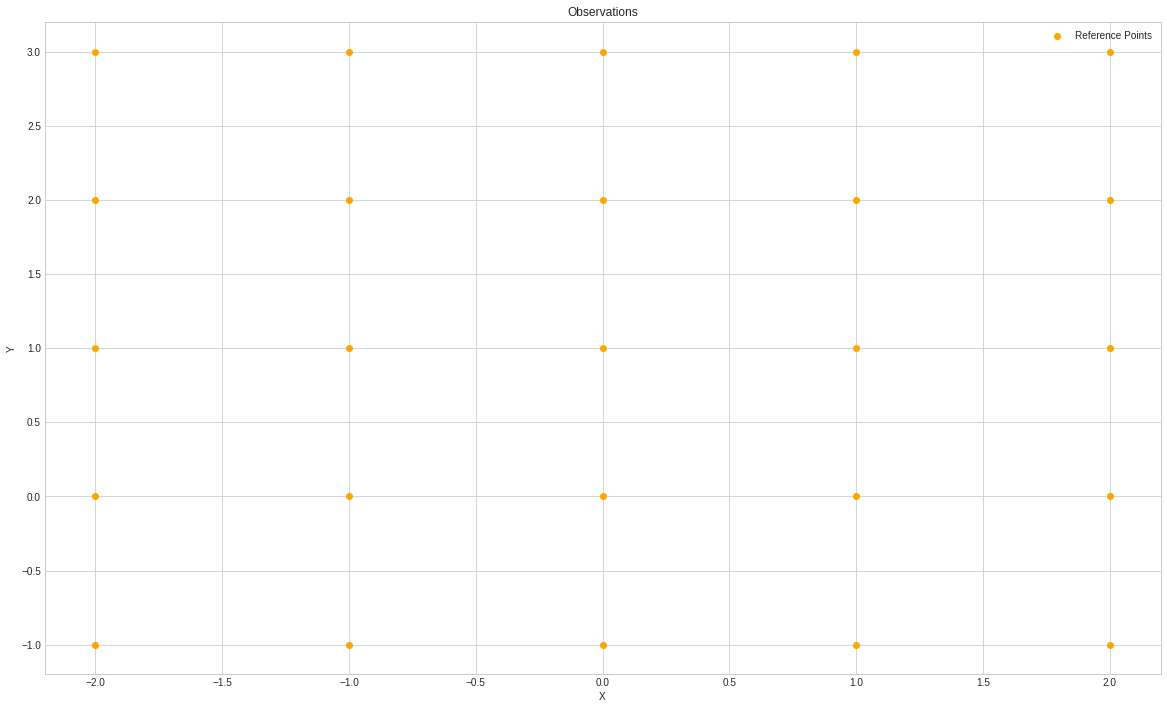

In [30]:
plt.figure(figsize=(20,12))
plt.scatter(dataset['X'],dataset['Y'],label='Reference Points',color='orange')
plt.title('Observations')  
plt.xlabel('X')  
plt.ylabel('Y')  
plt.legend(loc='upper right');
plt.show()

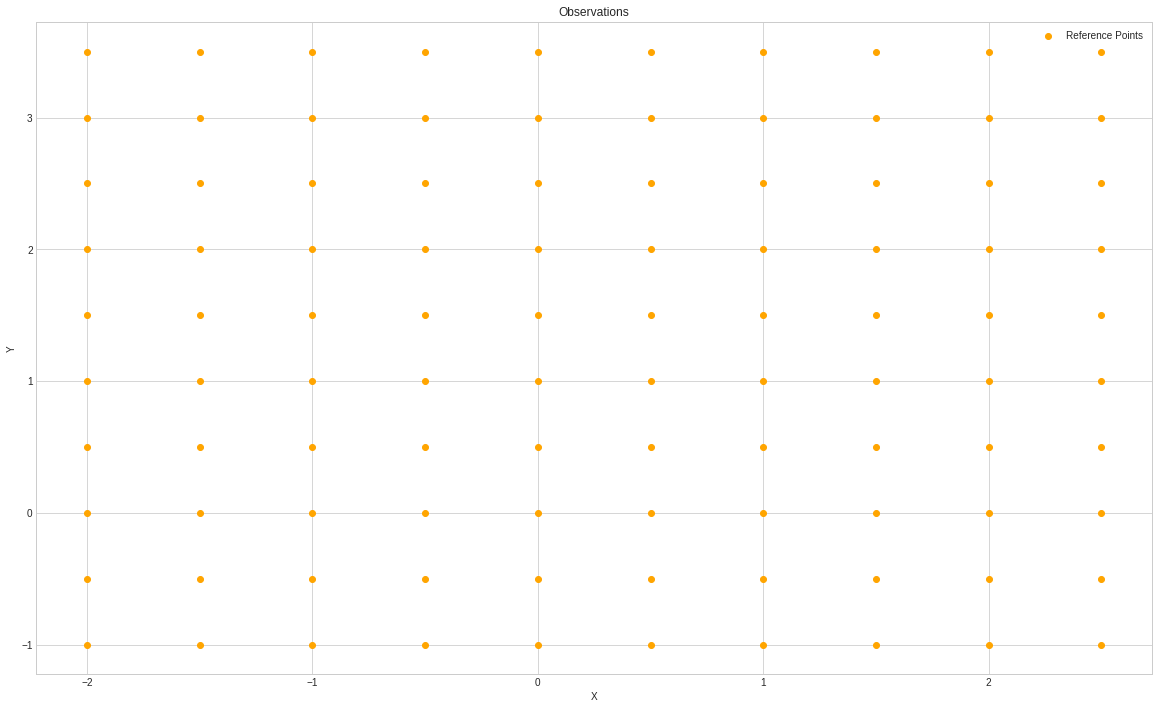

In [31]:
plt.figure(figsize=(20,12))
plt.scatter(dataset_double['X'],dataset_double['Y'],label='Reference Points',color='orange')
plt.title('Observations')  
plt.xlabel('X')  
plt.ylabel('Y')    
plt.legend(loc='upper right');
plt.show()

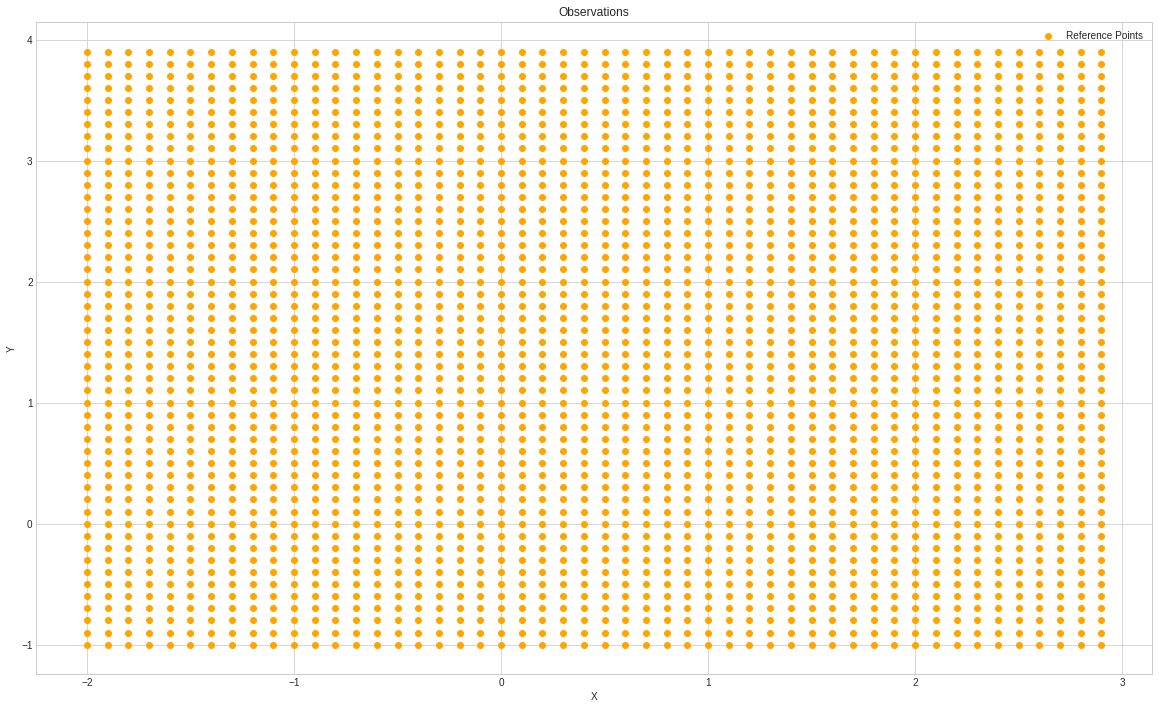

In [32]:
plt.figure(figsize=(20,12))
plt.scatter(dataset_10cm['X'],dataset_10cm['Y'],label='Reference Points',color='orange')
plt.title('Observations')  
plt.xlabel('X')  
plt.ylabel('Y')    
plt.legend(loc='upper right');
plt.show()

<AxesSubplot:xlabel='Zone'>

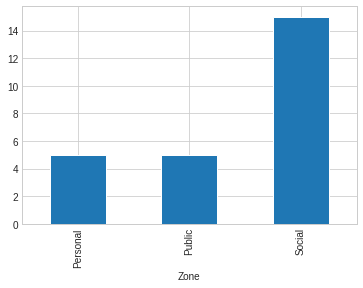

In [33]:
reference_points = dataset_classification.groupby(['Zone'])
reference_points.size().plot(kind="bar")

### Initialize Training Data
Training Data intialization for predictions purposes

In [34]:
trainX_data = train_dataset[['rssi_Value','rolling_mean_rssi']]
display(trainX_data.shape)
default_groups = train_dataset['labels'].values.reshape(-1,1)
initial_prediction = tuple()

(24834, 2)

In [35]:
train_Y = pd.DataFrame(train_dataset['distance']).values.reshape(-1,1)
display(train_Y.shape)

(24834, 1)

In [36]:
data_plot_means = train_dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
0.0,-48.351984,-48.325565
0.5,-75.304314,-75.253245
1.0,-74.156908,-74.155786
1.5,-78.266151,-78.279493
2.0,-74.711171,-74.732949
2.5,-82.396866,-82.373984
3.0,-79.297379,-79.557064
3.5,-86.335602,-86.250861
4.0,-84.817666,-84.750632


### Plot Training Data
Graphical Display of the observations in the dataset

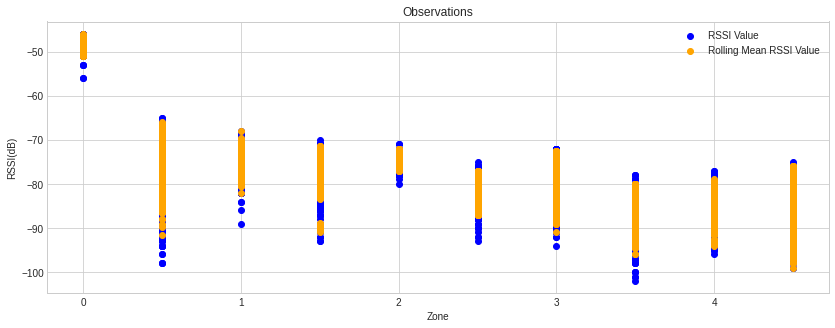

In [37]:
plt.figure(figsize=(14,5))
plt.scatter(train_dataset['distance'],train_dataset['rssi_Value'],label='RSSI Value',color='blue')
plt.scatter(train_dataset['distance'],train_dataset['rolling_mean_rssi'],label='Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Initialize Test Data

In [38]:
test_X_rssi = pd.DataFrame(test_dataset['rssi_Value']).values.reshape(-1,1)
display(test_X_rssi.shape)
test_X_rolling_mean = pd.DataFrame(test_dataset['rolling_mean_rssi']).values.reshape(-1,1)
display(test_X_rolling_mean.shape)
test_combination_features_X = test_dataset[['rssi_Value','rolling_mean_rssi']]
display(test_combination_features_X.shape)

(13478, 1)

(13478, 1)

(13478, 2)

In [39]:
test_Y = pd.DataFrame(test_dataset['distance']).values.reshape(-1,1)
display(test_Y.shape)

(13478, 1)

In [40]:
data_plot_means = test_dataset.groupby(['distance'])[['rssi_Value','rolling_mean_rssi']].mean()
display(data_plot_means)

,rssi_Value,rolling_mean_rssi
distance,,
-1.0,-84.395692,-84.171189
0.0,-84.685042,-84.442653
1.0,-86.000000,-85.916756
2.0,-85.490940,-85.350581
3.0,-81.762304,-81.866541


### Plot Test Data

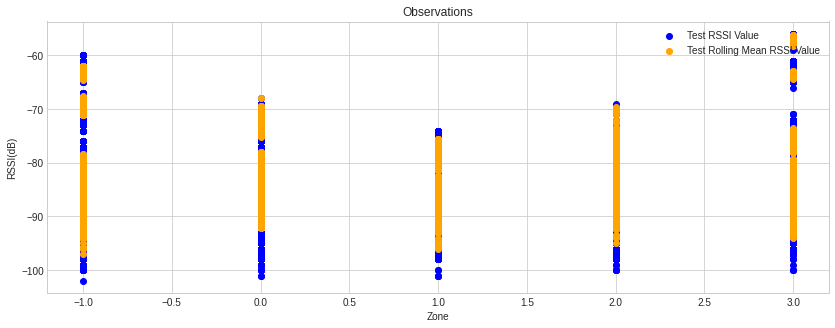

In [41]:
plt.figure(figsize=(14,5))
plt.scatter(test_dataset['distance'],test_dataset['rssi_Value'],label='Test RSSI Value',color='blue')
plt.scatter(test_dataset['distance'],test_dataset['rolling_mean_rssi'],label='Test Rolling Mean RSSI Value',color='orange')
plt.title('Observations')  
plt.xlabel('Zone')  
plt.ylabel('RSSI(dB)')  
plt.legend(loc='upper right');
plt.show()

### Statistics Output Format
Structure of the statistical output of each call to the machine learning algorithm

In [42]:
def structure_data(data):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    std = data['error'].std()
    q25 = data['error'].quantile(q=0.25)
    q50= data['error'].quantile(q=0.5)
    q75 =data['error'].quantile(q=0.7)
    q95= data['error'].quantile(q=0.95)
    minValue= data['error'].min()
    maxValue = data['error'].max()
    statistical_results = [mae,mse,rsme,std,q25,q50,q75,q95,minValue,maxValue]
    return statistical_results

### Proximity ML Algorithm to compute Distances

In [43]:
def compute_KNN_with_Regression(testX_data=None, scaler=None, n_neighbors=5,
                                weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski',
                                metric_params=None, n_jobs=1):
    # Init the KNN Regressor Estimator
    knn_regression_estimator = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, algorithm=algorithm, leaf_size=leaf_size, p=p, metric=metric, metric_params=metric_params,
                                                   n_jobs=n_jobs)
    if scaler is not None:
        # Make pipeline using scaler transformation
        main_estimator = make_pipeline(scaler, knn_regression_estimator)
    else:
        main_estimator = knn_regression_estimator
    # Fit the training data
    main_estimator.fit(trainX_data, train_Y)
    # Predict the results of the testing data features
    predict_test = main_estimator.predict(testX_data)
    return predict_test

In [44]:
print('This emulates that user is at one of the 25 reference points')
rf = test_dataset.groupby((['coordinate_X','coordinate_Y']))
for k1, v1 in rf:
    coordinate_test = k1
    test_point = v1
display(coordinate_test)
display(test_point)

This emulates that user is at one of the 25 reference points


(2.0, 3.0)

,BLE Beacon,coordinate_X,coordinate_Y,rssi_Value,rolling_mean_rssi,zone,distance,labels
1619,FF:20:88:3C:97:E7,2.0,3.0,-90,-90.000000,NaN,3.0,9489
1620,FF:20:88:3C:97:E7,2.0,3.0,-95,-92.500000,NaN,3.0,9490
1621,FF:20:88:3C:97:E7,2.0,3.0,-94,-93.000000,NaN,3.0,9491
1622,FF:20:88:3C:97:E7,2.0,3.0,-94,-93.250000,NaN,3.0,9492
1623,FF:20:88:3C:97:E7,2.0,3.0,-92,-93.000000,NaN,3.0,9493
...,...,...,...,...,...,...,...,...
2109,E1:E9:C3:D9:09:C3,2.0,3.0,-96,-91.566265,NaN,3.0,6873
2110,E1:E9:C3:D9:09:C3,2.0,3.0,-94,-91.580838,NaN,3.0,6874
2111,E1:E9:C3:D9:09:C3,2.0,3.0,-92,-91.583333,NaN,3.0,6875
2112,E1:E9:C3:D9:09:C3,2.0,3.0,-92,-91.585799,NaN,3.0,6876


In [45]:
distances = {}
beacons = []
def compute_distance(flag=0):
    rf = test_dataset.groupby((['coordinate_X','coordinate_Y']))
    for k1, v1 in rf:
        rfv = v1.groupby(['BLE Beacon'])
        empty_list = {}
        for k, v in rfv:
            test_combination_features_X = v[['rssi_Value','rolling_mean_rssi']]
            prediction_list = compute_KNN_with_Regression(testX_data=test_combination_features_X,scaler=StandardScaler(),n_neighbors=30,
                                                          metric='manhattan')
            distances[k1] = empty_list
            empty_list[k] = np.mean(prediction_list)
            beacons.append(k)
    if flag == 0:
        print("DISTANCES ESTIMATIONS")
        df = pd.DataFrame.from_dict(distances, orient='index')
        display(df)

### Compute Trilateration Method

In [46]:
def compute_squared_errors(d1,d2):
    squared_errors = math.pow(d1 - d2, 2.0)
    return squared_errors

In [47]:
def compute_display(results_mse):
    xs = []
    ys = []
    for k,v in results_mse.items():
        xs.append(str(k))
        ys.append(v)
    plt.figure(figsize=(23,8))
    plt.plot(xs,ys)
    plt.show()

In [48]:
def compute_trilateration(target,point,flag = 0):
    results_mse = {}
    for index, row in target.iterrows():
        x = row['X']
        y = row['Y']
        squared_errors = 0.0
        rfv = test_point.groupby(['BLE Beacon'])
        empty_list = {}
        for k, v in rfv:
            distance_known = row[k]
            squared_errors += compute_squared_errors(distance_known,distances[point][k])
        mse = squared_errors / len(rfv)
        if flag == 0:
            print('MSE FOR POINT: x: ' + str(x) + ", y: " + str(y) + " is " + str(mse))
        results_mse[(x,y)] = mse
    prediction = min(results_mse,key=results_mse.get)
    print("PREDICTION is " + str(prediction))
    if flag == 0:
        compute_display(results_mse)
    return prediction

In [49]:
def compute_trilateration_test_single_point(flag = 0):
    results_mse = {}
    for index, row in dataset.iterrows():
        x = row['X']
        y = row['Y']
        squared_errors = 0.0
        rfv = test_point.groupby(['BLE Beacon'])
        empty_list = {}
        for k, v in rfv:
            distance_known = row[k]
            squared_errors += compute_squared_errors(distance_known,distances[coordinate_test][k])
        mse = squared_errors / len(rfv)
        if flag == 0:
            print('MSE FOR POINT: x: ' + str(x) + ", y: " + str(y) + " is " + str(mse))
        results_mse[(x,y)] = mse
    prediction = min(results_mse,key=results_mse.get)
    print("PREDICTION is " + str(prediction))
    if flag == 0:
        compute_display(results_mse)
    return prediction

### Experiment - Compute Distances
Make initial prediction on distances 

In [50]:
compute_distance()

DISTANCES ESTIMATIONS


CA:E0:7D:11:26:B3  E1:E9:C3:D9:09:C3  FF:20:88:3C:97:E7
-2.0 -1.0           3.881303           0.516667           3.803229
      0.0           3.678667           0.886423           3.462121
      1.0           3.218172           1.711979           2.021979
      2.0           3.029124           4.123674           2.594000
      3.0           3.316476           3.481723           0.000092
-1.0 -1.0           3.906088           0.633431           3.349202
      0.0           4.101085           1.384964           3.543966
      1.0           3.962929           3.265321           3.188066
      2.0           3.417235           3.697853           1.526723
      3.0           3.856651           3.962379           1.529263
 0.0 -1.0           3.713988           2.468474           3.734053
      0.0           3.987298           2.477061           3.654167
      1.0           3.325326           3.550939           3.130636
      2.0           3.768082           3.949048           3.470771
      3.0           2.985045           3.854352           2.666667
 1.0 -1.0           3.527811           3.935164           3.590424
      0.0           3.369864           3.265294           3.317641
      1.0           3.984593           3.845376           3.853813
      2.0           2.472917           4.050952           3.717407
      3.0           1.579910           3.940918           2.916204
 2.0 -1.0           4.010458           3.916857           3.385405
      0.0           3.852841           3.382261           3.793289
      1.0           3.673099           4.041239           3.900482
      2.0           1.694107           3.579922           3.579023
      3.0           0.516667           4.088137           4.093764

### Experiment - Compute Trilateration
Make initial prediction on trilateration

MSE FOR POINT: x: -2.0, y: -1.0 is 14.381062107188926
MSE FOR POINT: x: -2.0, y: 0.0 is 10.277729849192058
MSE FOR POINT: x: -2.0, y: 1.0 is 8.129967631870187
MSE FOR POINT: x: -2.0, y: 2.0 is 7.920607134724164
MSE FOR POINT: x: -2.0, y: 3.0 is 9.633428128503784
MSE FOR POINT: x: -1.0, y: -1.0 is 9.879243467923965
MSE FOR POINT: x: -1.0, y: 0.0 is 7.300139145634836
MSE FOR POINT: x: -1.0, y: 1.0 is 5.474134629023145
MSE FOR POINT: x: -1.0, y: 2.0 is 5.012154996482597
MSE FOR POINT: x: -1.0, y: 3.0 is 5.246514661807447
MSE FOR POINT: x: 0.0, y: -1.0 is 6.716406564056899
MSE FOR POINT: x: 0.0, y: 0.0 is 4.403240189144586
MSE FOR POINT: x: 0.0, y: 1.0 is 2.8440612905198015
MSE FOR POINT: x: 0.0, y: 2.0 is 2.2134217491840738
MSE FOR POINT: x: 0.0, y: 3.0 is 2.243860396270208
MSE FOR POINT: x: 1.0, y: -1.0 is 5.003902675162561
MSE FOR POINT: x: 1.0, y: 0.0 is 2.626212578250496
MSE FOR POINT: x: 1.0, y: 1.0 is 1.1425273093055135
MSE FOR POINT: x: 1.0, y: 2.0 is 0.565709620969545
MSE FOR POIN

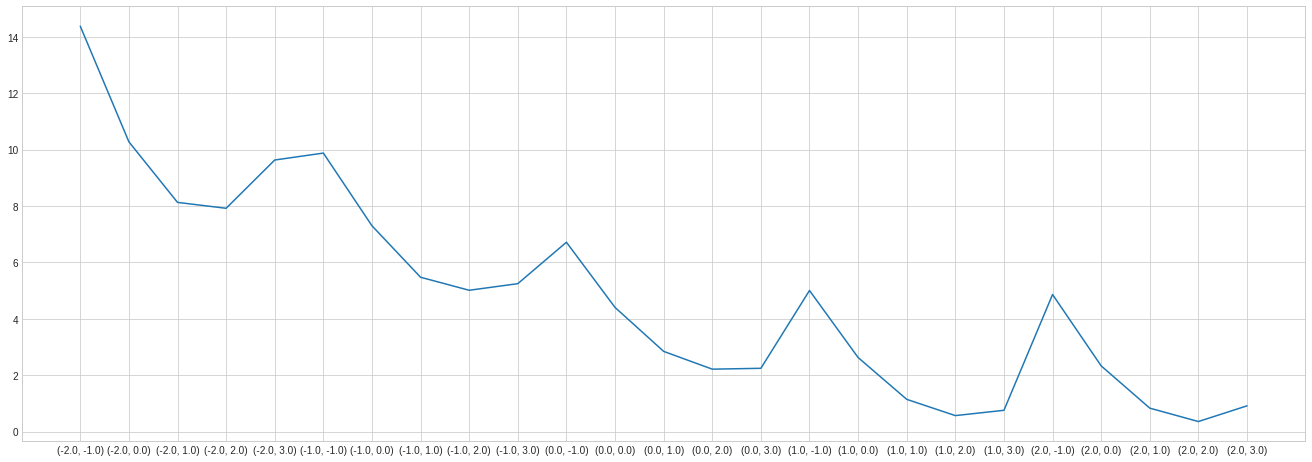

In [51]:
initial_prediction = compute_trilateration_test_single_point()

### Experiment - Make several runs on Trilateration
This experiment allows to check the consistency of the predictions

In [52]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max']
runs = list(range(1, 31))
predictions = list()
actual = list()
results_stats = list()
for run in runs:
    compute_distance(flag=1)
    prediction = compute_trilateration_test_single_point(flag=1)
    predictions.append(prediction)
    actual.append((2.0,3.0))
results = list(zip(actual,predictions))
error_dataframe = pd.DataFrame(results,columns=['Actual','Prediction'])
observed_errors = list()
for index, row in error_dataframe.iterrows():
        x1 = row['Actual']
        x2 = row['Prediction']
        error = math.hypot(x2[0] - x1[0], x2[1] - x1[1])
        observed_errors.append(error)
error = pd.DataFrame(observed_errors, columns=["error"])
result = error_dataframe.join(error)
display(result)
stats = structure_data(result)
results_stats.append(stats)
statistics = pd.DataFrame(columns=statistical_cols,data=results_stats)
display(statistics)

PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)
PREDICTION is (2.0, 2.0)


,Actual,Prediction,error
0,"(2.0, 3.0)","(2.0, 2.0)",1.0
1,"(2.0, 3.0)","(2.0, 2.0)",1.0
2,"(2.0, 3.0)","(2.0, 2.0)",1.0
3,"(2.0, 3.0)","(2.0, 2.0)",1.0
4,"(2.0, 3.0)","(2.0, 2.0)",1.0
5,"(2.0, 3.0)","(2.0, 2.0)",1.0
6,"(2.0, 3.0)","(2.0, 2.0)",1.0
7,"(2.0, 3.0)","(2.0, 2.0)",1.0
8,"(2.0, 3.0)","(2.0, 2.0)",1.0
9,"(2.0, 3.0)","(2.0, 2.0)",1.0


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0


### Experiment - Having data labeled to a certain position, can the algorithm correctly figure the position - 1 meter apart known points (Brute Force)

In [53]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max']
predictions = list()
bf_results = list()
actual = list()
for k,v in distances.items():
    print(k)
    prediction = compute_trilateration(dataset,k,flag=1)
    results_stats = list()
    predictions.append(prediction)
    actual.append(k)
results = list(zip(actual,predictions))
error_dataframe = pd.DataFrame(results,columns=['Actual','Prediction'])
observed_errors = list()
for index, row in error_dataframe.iterrows():
        x1 = row['Actual']
        x2 = row['Prediction']
        error = math.hypot(x2[0] - x1[0], x2[1] - x1[1])
        observed_errors.append(error)
error = pd.DataFrame(observed_errors, columns=["error"])
result = error_dataframe.join(error)
display(result)
stats = structure_data(result)
results_stats.append(stats)
statistics = pd.DataFrame(columns=statistical_cols,data=results_stats)
display(statistics)
bf_results.append(statistics.sort_values(by=['mae']).head(1).values[0])

(-2.0, -1.0)
PREDICTION is (-1.0, 0.0)
(-2.0, 0.0)
PREDICTION is (-1.0, 0.0)
(-2.0, 1.0)
PREDICTION is (-1.0, 1.0)
(-2.0, 2.0)
PREDICTION is (0.0, 2.0)
(-2.0, 3.0)
PREDICTION is (-2.0, 3.0)
(-1.0, -1.0)
PREDICTION is (-1.0, 0.0)
(-1.0, 0.0)
PREDICTION is (-1.0, 0.0)
(-1.0, 1.0)
PREDICTION is (0.0, 0.0)
(-1.0, 2.0)
PREDICTION is (-1.0, 2.0)
(-1.0, 3.0)
PREDICTION is (-1.0, 3.0)
(0.0, -1.0)
PREDICTION is (0.0, 0.0)
(0.0, 0.0)
PREDICTION is (0.0, 0.0)
(0.0, 1.0)
PREDICTION is (0.0, 1.0)
(0.0, 2.0)
PREDICTION is (1.0, 0.0)
(0.0, 3.0)
PREDICTION is (0.0, 2.0)
(1.0, -1.0)
PREDICTION is (1.0, 0.0)
(1.0, 0.0)
PREDICTION is (0.0, 1.0)
(1.0, 1.0)
PREDICTION is (1.0, 0.0)
(1.0, 2.0)
PREDICTION is (1.0, 1.0)
(1.0, 3.0)
PREDICTION is (1.0, 2.0)
(2.0, -1.0)
PREDICTION is (1.0, 0.0)
(2.0, 0.0)
PREDICTION is (1.0, 0.0)
(2.0, 1.0)
PREDICTION is (1.0, 0.0)
(2.0, 2.0)
PREDICTION is (1.0, 1.0)
(2.0, 3.0)
PREDICTION is (2.0, 2.0)


,Actual,Prediction,error
0,"(-2.0, -1.0)","(-1.0, 0.0)",1.414214
1,"(-2.0, 0.0)","(-1.0, 0.0)",1.000000
2,"(-2.0, 1.0)","(-1.0, 1.0)",1.000000
3,"(-2.0, 2.0)","(0.0, 2.0)",2.000000
4,"(-2.0, 3.0)","(-2.0, 3.0)",0.000000
5,"(-1.0, -1.0)","(-1.0, 0.0)",1.000000
6,"(-1.0, 0.0)","(-1.0, 0.0)",0.000000
7,"(-1.0, 1.0)","(0.0, 0.0)",1.414214
8,"(-1.0, 2.0)","(-1.0, 2.0)",0.000000
9,"(-1.0, 3.0)","(-1.0, 3.0)",0.000000


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max
0,0.948854,1.28,1.131371,0.628885,1.0,1.0,1.331371,1.882843,0.0,2.236068


### Experiment - Having data labeled to a certain position, can the algorithm correctly figure the position - 0.5 meter apart known points (Brute Force | Doubled Number of Points Known)

In [54]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max']
predictions = list()
actual = list()
for k,v in distances.items():
    print(k)
    prediction = compute_trilateration(dataset_double,k,flag=1)
    results_stats = list()
    predictions.append(prediction)
    actual.append(k)
results = list(zip(actual,predictions))
error_dataframe = pd.DataFrame(results,columns=['Actual','Prediction'])
observed_errors = list()
for index, row in error_dataframe.iterrows():
        x1 = row['Actual']
        x2 = row['Prediction']
        error = math.hypot(x2[0] - x1[0], x2[1] - x1[1])
        observed_errors.append(error)
error = pd.DataFrame(observed_errors, columns=["error"])
result = error_dataframe.join(error)
display(result)
stats = structure_data(result)
results_stats.append(stats)
statistics = pd.DataFrame(columns=statistical_cols,data=results_stats)
display(statistics)
bf_results.append(statistics.sort_values(by=['mae']).head(1).values[0])

(-2.0, -1.0)
PREDICTION is (-1.0, -0.5)
(-2.0, 0.0)
PREDICTION is (-1.0, 0.0)
(-2.0, 1.0)
PREDICTION is (-1.0, 1.0)
(-2.0, 2.0)
PREDICTION is (0.0, 2.0)
(-2.0, 3.0)
PREDICTION is (-1.5, 2.5)
(-1.0, -1.0)
PREDICTION is (-1.0, 0.0)
(-1.0, 0.0)
PREDICTION is (-0.5, -0.5)
(-1.0, 1.0)
PREDICTION is (0.0, 0.5)
(-1.0, 2.0)
PREDICTION is (-1.0, 2.5)
(-1.0, 3.0)
PREDICTION is (-1.0, 2.5)
(0.0, -1.0)
PREDICTION is (0.0, 0.0)
(0.0, 0.0)
PREDICTION is (0.0, 0.0)
(0.0, 1.0)
PREDICTION is (0.5, 0.5)
(0.0, 2.0)
PREDICTION is (1.0, 0.0)
(0.0, 3.0)
PREDICTION is (0.0, 1.5)
(1.0, -1.0)
PREDICTION is (1.0, 0.5)
(1.0, 0.0)
PREDICTION is (0.5, 0.5)
(1.0, 1.0)
PREDICTION is (1.0, 0.0)
(1.0, 2.0)
PREDICTION is (1.0, 1.0)
(1.0, 3.0)
PREDICTION is (0.5, 2.0)
(2.0, -1.0)
PREDICTION is (1.0, 0.0)
(2.0, 0.0)
PREDICTION is (1.0, 0.0)
(2.0, 1.0)
PREDICTION is (1.5, 0.0)
(2.0, 2.0)
PREDICTION is (1.0, 1.5)
(2.0, 3.0)
PREDICTION is (1.5, 2.0)


,Actual,Prediction,error
0,"(-2.0, -1.0)","(-1.0, -0.5)",1.118034
1,"(-2.0, 0.0)","(-1.0, 0.0)",1.000000
2,"(-2.0, 1.0)","(-1.0, 1.0)",1.000000
3,"(-2.0, 2.0)","(0.0, 2.0)",2.000000
4,"(-2.0, 3.0)","(-1.5, 2.5)",0.707107
5,"(-1.0, -1.0)","(-1.0, 0.0)",1.000000
6,"(-1.0, 0.0)","(-0.5, -0.5)",0.707107
7,"(-1.0, 1.0)","(0.0, 0.5)",1.118034
8,"(-1.0, 2.0)","(-1.0, 2.5)",0.500000
9,"(-1.0, 3.0)","(-1.0, 2.5)",0.500000


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max
0,1.047477,1.3,1.140175,0.459611,0.707107,1.0,1.118034,1.9,0.0,2.236068


### Experiment - Having data labeled to a certain position, can the algorithm correctly figure the position - 0.10 meter apart known points (Brute Force | Increased Number of Points Known)

In [55]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max']
predictions = list()
actual = list()
for k,v in distances.items():
    print(k)
    prediction = compute_trilateration(dataset_10cm,k,flag=1)
    results_stats = list()
    predictions.append(prediction)
    actual.append(k)
results = list(zip(actual,predictions))
error_dataframe = pd.DataFrame(results,columns=['Actual','Prediction'])
observed_errors = list()
for index, row in error_dataframe.iterrows():
        x1 = row['Actual']
        x2 = row['Prediction']
        error = math.hypot(x2[0] - x1[0], x2[1] - x1[1])
        observed_errors.append(error)
error = pd.DataFrame(observed_errors, columns=["error"])
result = error_dataframe.join(error)
display(result)
stats = structure_data(result)
results_stats.append(stats)
statistics = pd.DataFrame(columns=statistical_cols,data=results_stats)
display(statistics)
bf_results.append(statistics.sort_values(by=['mae']).head(1).values[0])

(-2.0, -1.0)
PREDICTION is (-0.9999999999999992, -0.4000000000000001)
(-2.0, 0.0)
PREDICTION is (-0.8999999999999989, -0.1000000000000002)
(-2.0, 1.0)
PREDICTION is (-0.9999999999999992, 0.9999999999999996)
(-2.0, 2.0)
PREDICTION is (1.7763568394002505e-15, 1.8999999999999997)
(-2.0, 3.0)
PREDICTION is (-1.6999999999999995, 2.6999999999999997)
(-1.0, -1.0)
PREDICTION is (-1.0999999999999992, -0.20000000000000015)
(-1.0, 0.0)
PREDICTION is (-0.6999999999999988, -0.30000000000000016)
(-1.0, 1.0)
PREDICTION is (0.20000000000000195, 0.2999999999999998)
(-1.0, 2.0)
PREDICTION is (-0.9999999999999992, 2.2999999999999994)
(-1.0, 3.0)
PREDICTION is (-1.1999999999999993, 2.3999999999999995)
(0.0, -1.0)
PREDICTION is (0.20000000000000195, -0.1000000000000002)
(0.0, 0.0)
PREDICTION is (0.10000000000000188, -0.20000000000000015)
(0.0, 1.0)
PREDICTION is (0.4000000000000021, 0.6999999999999997)
(0.0, 2.0)
PREDICTION is (1.0000000000000029, 0.19999999999999973)
(0.0, 3.0)
PREDICTION is (0.1000000000

,Actual,Prediction,error
0,"(-2.0, -1.0)","(-0.9999999999999992, -0.4000000000000001)",1.166190
1,"(-2.0, 0.0)","(-0.8999999999999989, -0.1000000000000002)",1.104536
2,"(-2.0, 1.0)","(-0.9999999999999992, 0.9999999999999996)",1.000000
3,"(-2.0, 2.0)","(1.7763568394002505e-15, 1.8999999999999997)",2.002498
4,"(-2.0, 3.0)","(-1.6999999999999995, 2.6999999999999997)",0.424264
5,"(-1.0, -1.0)","(-1.0999999999999992, -0.20000000000000015)",0.806226
6,"(-1.0, 0.0)","(-0.6999999999999988, -0.30000000000000016)",0.424264
7,"(-1.0, 1.0)","(0.20000000000000195, 0.2999999999999998)",1.389244
8,"(-1.0, 2.0)","(-0.9999999999999992, 2.2999999999999994)",0.300000
9,"(-1.0, 3.0)","(-1.1999999999999993, 2.3999999999999995)",0.632456


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max
0,1.044542,1.306,1.142804,0.473168,0.781025,1.104536,1.204159,1.927575,0.223607,2.059126


### Brute Force Results

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,type
0,0.9488539740695345,1.28,1.131370849898476,0.6288847071506593,1.0,1.0,1.3313708498984749,1.8828427124746174,0.0,2.23606797749979,1.0 meters
2,1.0445417658397018,1.3060000000000005,1.1428035701729324,0.4731680676308352,0.7810249675906635,1.1045361017187272,1.2041594578792298,1.927575163482057,0.22360679774997994,2.0591260281974018,0.10 meters
1,1.0474765038847378,1.3,1.140175425099138,0.45961144573592344,0.7071067811865476,1.0,1.118033988749895,1.8999999999999986,0.0,2.23606797749979,0.5 meters


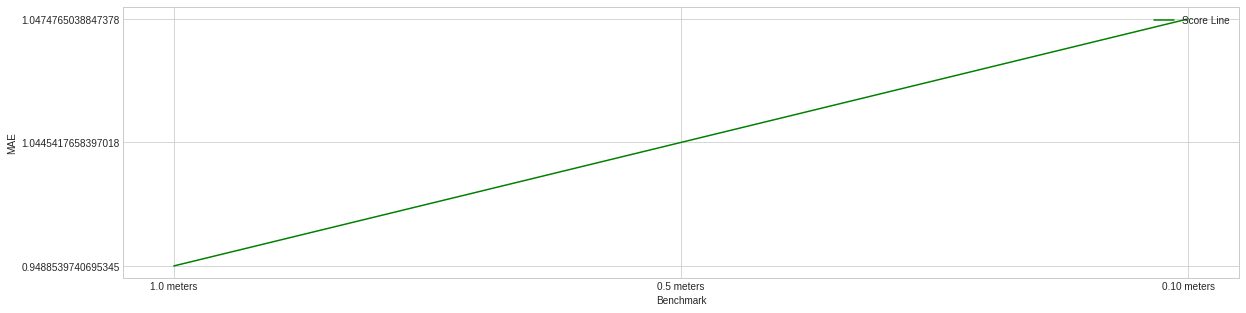

In [56]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','type']
types = ['1.0 meters',"0.5 meters","0.10 meters"]
for i in range(len(bf_results)):
    bf_results[i] = np.append(bf_results[i],types[i])
results = pd.DataFrame(data=bf_results,columns=statistical_cols)
display(results.sort_values(by=['mae']))
plt.figure(figsize=(20,5))
plt.plot(types,results.sort_values(by=['mae'])['mae'],color='green',label='Score Line')
plt.xlabel('Benchmark')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.gca()
plt.show()

In [57]:
final_results = list()
final_results.append(results.sort_values(by=['mae']).head(1).values[0])

### Experiment - Least Square Methods (Using Scipy Minimize Function)

In [58]:
def load_access_points_locations():
    with open('access_points_location.json') as json_file:
        data = json.load(json_file)
        access_points = {}
        for k, v in data.items():
            print('KEY: ' + k)
            access_points[k] = v
            print('X: ', v['x'])
            print('Y: ', v['y'])
            print('')
        return access_points

In [59]:
aps = load_access_points_locations()

KEY: FF:20:88:3C:97:E7
X:  -2.0
Y:  3.0

KEY: CA:E0:7D:11:26:B3
X:  2.0
Y:  3.0

KEY: E1:E9:C3:D9:09:C3
X:  -2.0
Y:  -1.0



In [60]:
def compute_distance_coordinate_system(x1,y1,x2,y2):
    dist = math.hypot(x2 - x1, y2 - y1)
    return dist

In [61]:
def mse(x,distances,beacons):
    squared_errors = 0.0
    rfv = test_point.groupby(['BLE Beacon'])
    empty_list = {}
    for k, v in rfv:
        distance_known = distances[k]
        distance_computed = compute_distance_coordinate_system(x[0],x[1],beacons[k]['x'],beacons[k]['y'])
        squared_errors += compute_squared_errors(distance_known,distance_computed)
    mse = squared_errors / len(rfv)
    return mse

In [62]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max']
predictions = list()
actual = list()
for index, row in dataset.iterrows():
    min_distance = float('inf')
    closest_location = None
    x = row['X']
    y = row['Y']
    print("X: " + str(x))
    print("Y: " + str(y))
    rfv = test_point.groupby(['BLE Beacon'])

#NOTE: Using closed location!
#     for k, v in rfv:
#         distance_known = distances[(x,y)][k]
#         if distance_known < min_distance:
#             min_distance = distance_known
#             closest_location = aps[k]
#     initial_location = closest_location
#     initial_location_tuple = (initial_location['x'],initial_location['y'])
    
#NOTE: Using (0,0)!
#     initial_location_tuple = (0,0)
    
#NOTE: Using mean!
#     x_acc=0
#     y_acc=0
#     for k,v in aps.items():
#         x_acc += v['x']
#         y_acc += v['y']
#     initial_location_tuple = (x_acc/len(aps), y_acc/len(aps))
    
#NOTE: Weighted Average based on https://github.com/kamalshadi/Localization/blob/master/localization/methods.py#L47
    l = len(aps)
    r = [distances[(x,y)][key] for key in sorted(distances[(x,y)].keys())]
    c = [aps[key] for key in sorted(aps.keys())]
    S = sum(r)
    W = [(S - w) / ((l - 1) * S) for w in r]
    
    initial_location_tuple = (0,0)
    for i in range(l):
        initial_location_tuple = (initial_location_tuple[0] + W[i] * c[i]['x'], initial_location_tuple[1] + W[i] * c[i]['y'])
        
    result = opt.minimize(
     mse,                         # The error function
     initial_location_tuple,
     args=(distances[(x,y)],aps),# The initial guess
     method='L-BFGS-B',           # The optimisation algorithm
     options={
     'ftol':1e-5,         # Tolerance
     'maxiter': 1e+7      # Maximum iterations
     })
    prediction = tuple(result.x)
    print("GUESSED: " + str(prediction))
    results_stats = list()
    predictions.append(prediction)
    actual.append((x,y))
results = list(zip(actual,predictions))
error_dataframe = pd.DataFrame(results,columns=['Actual','Prediction'])
observed_errors = list()
for index, row in error_dataframe.iterrows():
        x1 = row['Actual']
        x2 = row['Prediction']
        error = math.hypot(x2[0] - x1[0], x2[1] - x1[1])
        observed_errors.append(error)
error = pd.DataFrame(observed_errors, columns=["error"])
result = error_dataframe.join(error)
display(result)
stats = structure_data(result)
results_stats.append(stats)
statistics = pd.DataFrame(columns=statistical_cols,data=results_stats)
display(statistics)
to_append=statistics.sort_values(by=['mae']).head(1).values[0]
to_append = np.append(to_append,'Minimize')
final_results.append(to_append)

X: -2.0
Y: -1.0
GUESSED: (-1.0275315099328919, -0.43799314455189875)
X: -2.0
Y: 0.0
GUESSED: (-0.8631794702491774, -0.14899528157952402)
X: -2.0
Y: 1.0
GUESSED: (-0.9975204224912874, 0.9691687991785918)
X: -2.0
Y: 2.0
GUESSED: (-0.024678412722985075, 1.9001829630030938)
X: -2.0
Y: 3.0
GUESSED: (-1.6666384540295514, 2.7463730529343713)
X: -1.0
Y: -1.0
GUESSED: (-1.1278637413440875, -0.19840619649435623)
X: -1.0
Y: 0.0
GUESSED: (-0.7034333179654878, -0.25064270654954224)
X: -1.0
Y: 1.0
GUESSED: (0.23265556821809788, 0.2775793366162264)
X: -1.0
Y: 2.0
GUESSED: (-1.0050481993143938, 2.2871486241457126)
X: -1.0
Y: 3.0
GUESSED: (-1.2403546494076043, 2.421802315646266)
X: 0.0
Y: -1.0
GUESSED: (0.18955109641733722, -0.112280003818321)
X: 0.0
Y: 0.0
GUESSED: (0.08797090382892316, -0.1979129580750064)
X: 0.0
Y: 1.0
GUESSED: (0.4302002105178896, 0.7279284559163536)
X: 0.0
Y: 2.0
GUESSED: (0.959436411735229, 0.17488664138216303)
X: 0.0
Y: 3.0
GUESSED: (0.0737484245496773, 1.5665383407213003)
X: 1.

,Actual,Prediction,error
0,"(-2.0, -1.0)","(-1.0275315099328919, -0.43799314455189875)",1.123186
1,"(-2.0, 0.0)","(-0.8631794702491774, -0.14899528157952402)",1.146543
2,"(-2.0, 1.0)","(-0.9975204224912874, 0.9691687991785918)",1.002954
3,"(-2.0, 2.0)","(-0.024678412722985075, 1.9001829630030938)",1.977842
4,"(-2.0, 3.0)","(-1.6666384540295514, 2.7463730529343713)",0.418875
5,"(-1.0, -1.0)","(-1.1278637413440875, -0.19840619649435623)",0.811728
6,"(-1.0, 0.0)","(-0.7034333179654878, -0.25064270654954224)",0.388296
7,"(-1.0, 1.0)","(0.23265556821809788, 0.2775793366162264)",1.428752
8,"(-1.0, 2.0)","(-1.0050481993143938, 2.2871486241457126)",0.287193
9,"(-1.0, 3.0)","(-1.2403546494076043, 2.421802315646266)",0.626165


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max
0,1.041344,1.299663,1.140028,0.473535,0.73625,1.123186,1.228015,1.89558,0.216584,2.06193


#### Graphical View for point (-1,-1)

(-2.0, 3.0)

(2.0, 3.0)

(-2.0, -1.0)

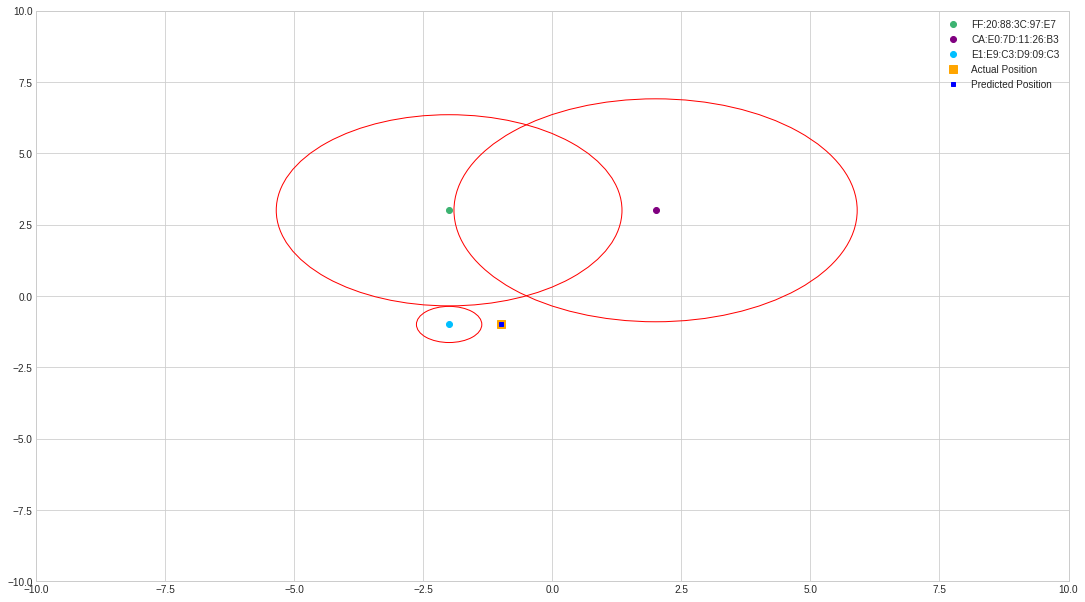

In [63]:
aux_list = list()
colors=['mediumseagreen','purple','deepskyblue']
counter = 0
for k, v in aps.items():
    coordinates = (v['x'],v['y'])
    display(coordinates)
    ap = plt.Circle(coordinates,distances[(-1.0,-1.0)][k],color='r',fill=False,label=str(k))
    aux_list.append(ap)
fig, ax = plt.subplots()
ax = plt.gca()
ax.cla() # clear things for fresh plot
ax.set_xlim((-10, 10))
ax.set_ylim((-10, 10))
fig.set_size_inches(18.5, 10.5, forward=True)
for k, v in aps.items():
    coordinates = (v['x'],v['y'])
    ax.plot(v['x'],v['y'],'o',color=colors[counter],label=str(k))
    counter += 1
ax.plot(-1.0,-1.0,'s',color='orange',label='Actual Position',markersize =8)
ax.plot(-1.00009551, -1.00015316,'s',color='blue',label='Predicted Position',markersize =4)
for element in aux_list:
    ax.add_artist(element)
plt.legend(loc='upper right');

### Experiment - Least Square Methods (Localization Package)

In [64]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max']
predictions = list()
actual = list()

for index, row in dataset.iterrows():
    x = row['X']
    y = row['Y']
    print("X: " + str(x))
    print("Y: " + str(y))
    P=lx.Project(mode='2D',solver='LSE')
    rfv = test_point.groupby(['BLE Beacon'])
    for k, v in aps.items():
        coordinates = (v['x'],v['y'])
        P.add_anchor(str(k),coordinates)
    t,label=P.add_target()
    for k, v in rfv:
        distance_known = distances[(x,y)][k]
        t.add_measure(str(k),distance_known)
    P.solve()
    print("PREDICTED LOCATION: ("+ str(t.loc.x) +","+str(t.loc.y)+")")
    prediction = (t.loc.x,t.loc.y)
    results_stats = list()
    predictions.append(prediction)
    actual.append((x,y))
results = list(zip(actual,predictions))
error_dataframe = pd.DataFrame(results,columns=['Actual','Prediction'])
observed_errors = list()
for index, row in error_dataframe.iterrows():
        x1 = row['Actual']
        x2 = row['Prediction']
        error = math.hypot(x2[0] - x1[0], x2[1] - x1[1])
        observed_errors.append(error)
error = pd.DataFrame(observed_errors, columns=["error"])
result = error_dataframe.join(error)
display(result)
stats = structure_data(result)
results_stats.append(stats)
statistics = pd.DataFrame(columns=statistical_cols,data=results_stats)
display(statistics)
to_append=statistics.sort_values(by=['mae']).head(1).values[0]
to_append = np.append(to_append,'Localization Package')
final_results.append(to_append)

X: -2.0
Y: -1.0
LSE Geolocating...
PREDICTED LOCATION: (-1.0275334012884816,-0.43799525101417824)
X: -2.0
Y: 0.0
LSE Geolocating...
PREDICTED LOCATION: (-0.8631711198821143,-0.14900531854677992)
X: -2.0
Y: 1.0
LSE Geolocating...
PREDICTED LOCATION: (-0.9975342100508757,0.9691612879363631)
X: -2.0
Y: 2.0
LSE Geolocating...
PREDICTED LOCATION: (-0.024613020390791482,1.9000156034372924)
X: -2.0
Y: 3.0
LSE Geolocating...
PREDICTED LOCATION: (-1.6666308487252297,2.7463643872155656)
X: -1.0
Y: -1.0
LSE Geolocating...
PREDICTED LOCATION: (-1.1278687165274728,-0.19841026285162686)
X: -1.0
Y: 0.0
LSE Geolocating...
PREDICTED LOCATION: (-0.703414781890502,-0.25062277960284157)
X: -1.0
Y: 1.0
LSE Geolocating...
PREDICTED LOCATION: (0.23262151690011615,0.2775735476561015)
X: -1.0
Y: 2.0
LSE Geolocating...
PREDICTED LOCATION: (-1.0034102422000895,2.2871306379385508)
X: -1.0
Y: 3.0
LSE Geolocating...
PREDICTED LOCATION: (-1.2406648386396364,2.4205739451622588)
X: 0.0
Y: -1.0
LSE Geolocating...
PREDI

,Actual,Prediction,error
0,"(-2.0, -1.0)","(-1.0275334012884816, -0.43799525101417824)",1.123183
1,"(-2.0, 0.0)","(-0.8631711198821143, -0.14900531854677992)",1.146552
2,"(-2.0, 1.0)","(-0.9975342100508757, 0.9691612879363631)",1.002940
3,"(-2.0, 2.0)","(-0.024613020390791482, 1.9000156034372924)",1.977916
4,"(-2.0, 3.0)","(-1.6666308487252297, 2.7463643872155656)",0.418887
5,"(-1.0, -1.0)","(-1.1278687165274728, -0.19841026285162686)",0.811724
6,"(-1.0, 0.0)","(-0.703414781890502, -0.25062277960284157)",0.388297
7,"(-1.0, 1.0)","(0.23262151690011615, 0.2775735476561015)",1.428725
8,"(-1.0, 2.0)","(-1.0034102422000895, 2.2871306379385508)",0.287151
9,"(-1.0, 3.0)","(-1.2406648386396364, 2.4205739451622588)",0.627419


,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max
0,1.041392,1.299729,1.140057,0.473497,0.736237,1.123183,1.228011,1.895565,0.216555,2.062048


### Best Results

,mae,mse,rmse,std,.25,0.5,0.75,0.95,min,max,type
0,0.9488539740695345,1.28,1.131370849898476,0.6288847071506593,1.0,1.0,1.3313708498984749,1.8828427124746174,0.0,2.23606797749979,1.0 meters
1,1.0413439478858009,1.2996629057380462,1.1400275899021244,0.47353467835398594,0.7362502872417783,1.1231859462012797,1.2280153458916585,1.895580254036112,0.21658351482621405,2.0619304061894654,Minimize
2,1.041392284070563,1.2997291790183443,1.1400566560563314,0.4734968427568091,0.7362366653750463,1.1231832546348641,1.2280111311621689,1.8955646392542627,0.21655486040071964,2.06204778897588,Localization Package


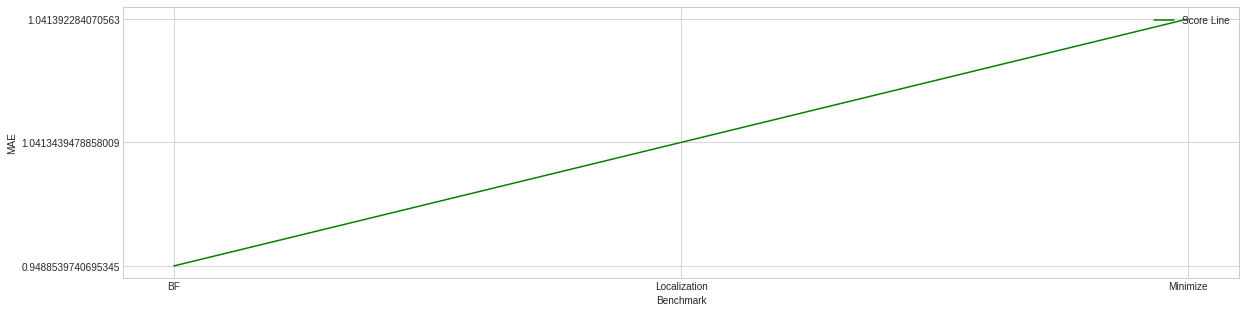

In [65]:
statistical_cols = ['mae','mse','rmse','std','.25','0.5','0.75','0.95','min','max','type']
results_regression = pd.DataFrame(data=final_results,columns=statistical_cols)
types=['BF','Localization','Minimize']
display(results_regression.sort_values(by=['mae']))
plt.figure(figsize=(20,5))
plt.plot(types,results_regression.sort_values(by=['mae'])['mae'],color='green',label='Score Line')
plt.xlabel('Benchmark')
plt.ylabel('MAE')
plt.legend(loc='upper right')
plt.gca()
plt.show()

### Experiment - Classification Accuracy (using Minimize)

In [66]:
def structure_data_classification(data,precision,accuracy,f1score):
    mae = data['error'].abs().mean()
    mse = np.power(data['error'],2).mean()
    rsme = np.sqrt(mse)
    precision = precision
    accuracy = accuracy
    f1score = f1score
    statistical_results = [mae,mse,rsme,precision,accuracy,f1score]
    return statistical_results

In [67]:
def check_zone(y):
    if y >= 3.0:
        return 'Personal'
    elif y >= 0.0 and y < 3.0:
        return 'Social'
    else:
        return 'Public'

In [68]:
statistical_cols = ['mae','mse','rmse','precision','accuracy','f1-score']
predictions = list()
actual = list()
for index, row in dataset_classification.iterrows():
    min_distance = float('inf')
    closest_location = None
    x = row['X']
    y = row['Y']
    zone = row['Zone']
    print("X: " + str(x))
    print("Y: " + str(y))
    rfv = test_point.groupby(['BLE Beacon'])
    for k, v in rfv:
        distance_known = distances[(x,y)][k]
        if distance_known < min_distance:
            min_distance = distance_known
            closest_location = aps[k]
    initial_location = closest_location
    initial_location_tuple = (initial_location['x'],initial_location['y'])
    result = opt.minimize(
     mse,                         # The error function
     initial_location_tuple,# The initial guess
    args=(distances[(x,y)],aps),
     method='L-BFGS-B',           # The optimisation algorithm
     options={
     'ftol':1e-5,         # Tolerance
     'maxiter': 1e+7      # Maximum iterations
     })
    prediction = result.x
    print("GUESSED: " + str(prediction))
    results_stats = list()
    predictions.append(check_zone(prediction[1]))
    actual.append(zone)
results = list(zip(actual,predictions))
matrix = confusion_matrix(actual, predictions)
report = classification_report(actual, predictions,output_dict=True)
accuracy = accuracy_score(actual, predictions)
print("Confusion Matrix:")
print(matrix)
statistical_array = list()
statistics = pd.DataFrame(report).transpose()
error_dataframe = pd.DataFrame(results,columns=['Actual','Predicted'])
error = pd.DataFrame(np.where(error_dataframe['Actual'] != error_dataframe['Predicted'],1,0), columns=["error"])
result = error_dataframe.join(error)
display(result)
stats = structure_data_classification(result,statistics['precision'].mean(),accuracy,statistics['f1-score'].mean())
results_stats.append(stats)
statistics = pd.DataFrame(columns=statistical_cols,data=results_stats)
display(statistics)

X: -2.0
Y: -1.0
GUESSED: [-1.02750041 -0.43790167]
X: -2.0
Y: 0.0
GUESSED: [-0.86317204 -0.14900492]
X: -2.0
Y: 1.0
GUESSED: [-0.99752731  0.96916398]
X: -2.0
Y: 2.0
GUESSED: [-0.02458642  1.90057217]
X: -2.0
Y: 3.0
GUESSED: [-1.66669109  2.74633487]
X: -1.0
Y: -1.0
GUESSED: [-1.12785158 -0.19840327]
X: -1.0
Y: 0.0
GUESSED: [-0.70341277 -0.25062419]
X: -1.0
Y: 1.0
GUESSED: [0.23262265 0.27757329]
X: -1.0
Y: 2.0
GUESSED: [-1.00341157  2.28713784]
X: -1.0
Y: 3.0
GUESSED: [-1.24062061  2.42066487]
X: 0.0
Y: -1.0
GUESSED: [ 0.18956525 -0.11228876]
X: 0.0
Y: 0.0
GUESSED: [ 0.08797463 -0.19791395]
X: 0.0
Y: 1.0
GUESSED: [0.43021216 0.72791173]
X: 0.0
Y: 2.0
GUESSED: [-0.59544338  4.2585846 ]
X: 0.0
Y: 3.0
GUESSED: [0.07378065 1.56652287]
X: 1.0
Y: -1.0
GUESSED: [1.05402186 0.2512751 ]
X: 1.0
Y: 0.0
GUESSED: [0.4434801  0.48201154]
X: 1.0
Y: 1.0
GUESSED: [ 1.1228915  -0.23390299]
X: 1.0
Y: 2.0
GUESSED: [1.27830075 0.89112044]
X: 1.0
Y: 3.0
GUESSED: [0.72822775 1.94094186]
X: 2.0
Y: -1.0
GUESS

,Actual,Predicted,error
0,Public,Public,0
1,Social,Public,1
2,Social,Social,0
3,Social,Social,0
4,Personal,Social,1
5,Public,Public,0
6,Social,Public,1
7,Social,Social,0
8,Social,Social,0
9,Personal,Social,1


,mae,mse,rmse,precision,accuracy,f1-score
0,0.56,0.56,0.748331,0.353294,0.44,0.36906
